In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

from cryptic_rnn import *

In [14]:
def run_exp(trainseqs_old , testseqs_old, final_train, final_test, cue_dict, xavier_gain, num_episodes):
    
    losses = np.empty((0,1))
    accs = np.empty((0,2))
    tests = []
    
    cue_dict_final = cue_dict.copy()
    train_inputs = convert_seq2inputs(final_train, num_classes=num_classes, seq_len=5)
    trainset_final = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    test_inputs = convert_seq2inputs(final_test, num_classes=num_classes, seq_len=5)
    testset_final = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # initialize RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    
    # repeat episodes of training with new input values
    for ep in range(num_episodes):

        all_syms = list(cue_dict.keys())
        all_input_vals = list(np.arange(2,18))
        input_vals = random.sample(all_input_vals,num_inputs)
        for i, s in enumerate(all_syms):
            cue_dict[s] = input_vals[i]

        trainseqs = change_dict(trainseqs_old, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

        testseqs = change_dict(testseqs_old, cue_dict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

        # run primitive training RNN
        loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
        losses = np.vstack([losses, loss1])
        accs = np.vstack([accs, acc1])
        tests.append(testset)
        
    loss, acc = run_acc(model,optimizer,criterion, trainset_final, [trainset_final, testset_final], epochs, hidden_size)
    losses = np.vstack([losses, loss])
    accs = np.vstack([accs, acc])
    tests.append(testset_final)
    
    return {'all_loss':losses, 'all_acc':accs, 'mod': model,\
            'loss':loss, 'acc':acc, 'test':testset_final, 'cue_dict':cue_dict_final
           }

def run_plot(trainseqs, testseqs, trainseqs_final, testseqs_final, cue_dict, xavier_gain, num_episodes):
    
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, trainseqs_final, testseqs_final, cue_dict, xavier_gain, num_episodes) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list = [r['acc'][:,1] for r in res]
    loss_list = [r['loss'] for r in res]
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    mods = [r['mod'] for r in res]
 
    # all RNNs plot accuracy
    losses = np.hstack([r['all_loss'] for r in res])
    acc_train = np.array([r['all_acc'][:,0] for r in res]).T
    acc_test = np.array([r['all_acc'][:,1] for r in res]).T
    
    r2, dfs, alldfs = predcorr(mods, tests, hidden_size, plot_corr = True)
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    # fully trained
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    ft_tests_acc = np.array([acc_test_list[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, hidden_size, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)

    return {'res':res, 'dfs':dfs, 'mods':mods, 
            'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':final_accs }


In [22]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
num_sims = 8
epochs = 1000
# 
xavier_gain = 0.001

In [23]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 2, 'B': 14, 'C': 10, 'D': 15}
[[('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]


trainseqs  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 17], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 29], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'C'), ('+', 'B'), '=', 24], [('+', 'C'), ('+', 'C'), '=', 20], [('+', 'D'), ('+', 'B'), '=', 29], [('+', 'D'), ('+', 'C'), '=', 25], [('+', 'D'), ('+', 'D'), '=', 30]]
trainseqs_final  [[('+', 'C'), ('+', 'D'), '=', 25], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs_final  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'B'), '=', 16], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=

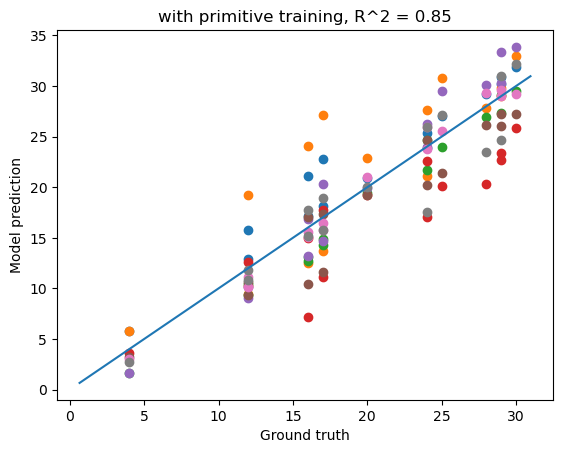

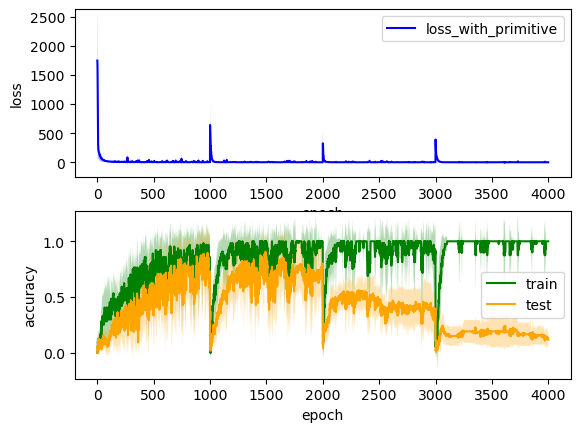

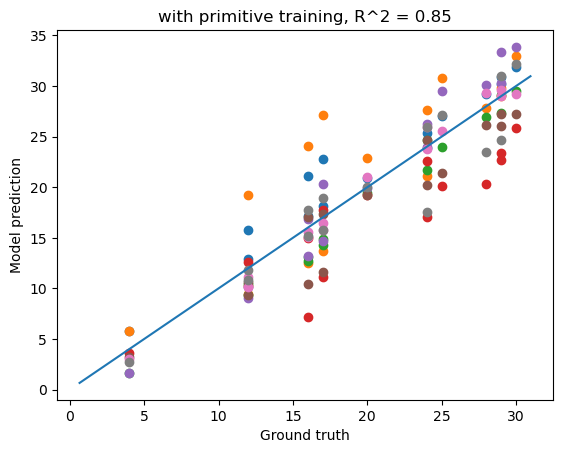

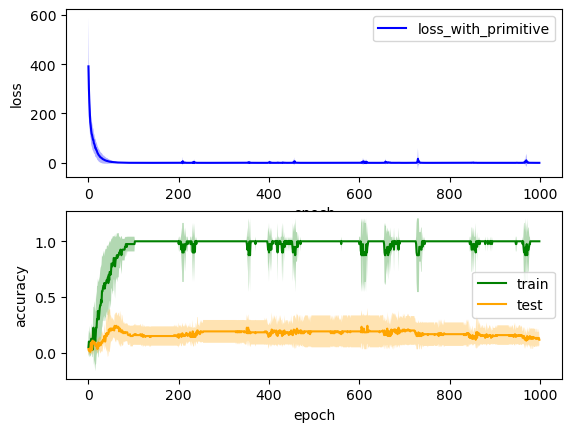

In [24]:
trainseqs = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs if seq not in trainseqs]

trainseqs_final = [random.choice(generate_pos_other(ops, all_syms, cue_dict))] + pos_primitives
testseqs_final = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs_final = [seq for seq in testseqs_final if seq not in trainseqs_final]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
print('trainseqs_final ', trainseqs_final)
print('testseqs_final ', testseqs_final )
res1 = run_plot(trainseqs, testseqs, trainseqs_final,testseqs_final, cue_dict, xavier_gain, num_episodes=3)


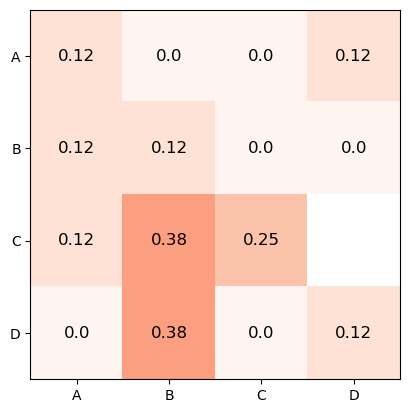

In [26]:
fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, res1['dfs'], ax)

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 17], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 29], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'C'), ('+', 'B'), '=', 24], [('+', 'C'), ('+', 'C'), '=', 20], [('+', 'D'), ('+', 'B'), '=', 29], [('+', 'D'), ('+', 'C'), '=', 25], [('+', 'D'), ('+', 'D'), '=', 30]]
trainseqs_final  [[('+', 'C'), ('+', 'D'), '=', 25], [('+', 'A'), ('+', 'B'), '=', 16], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs_final  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=

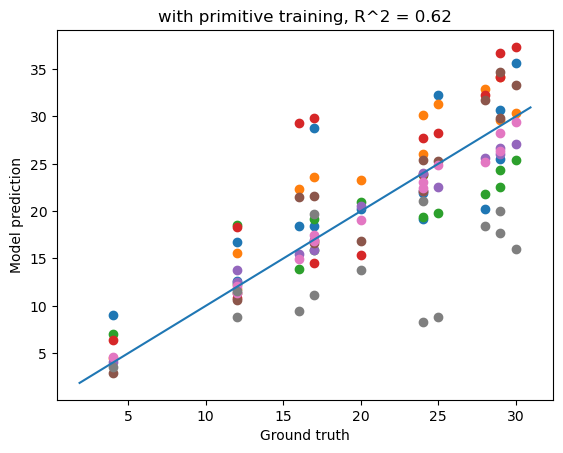

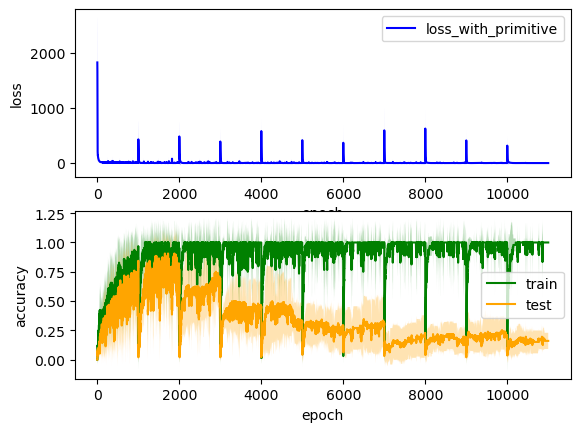

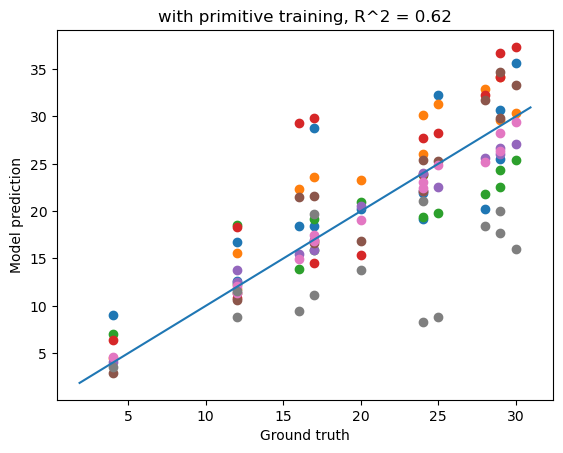

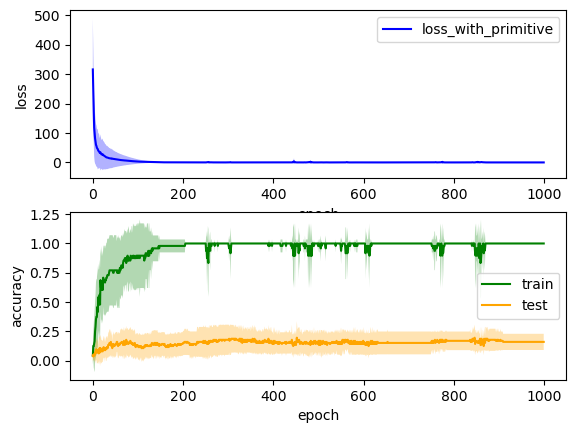

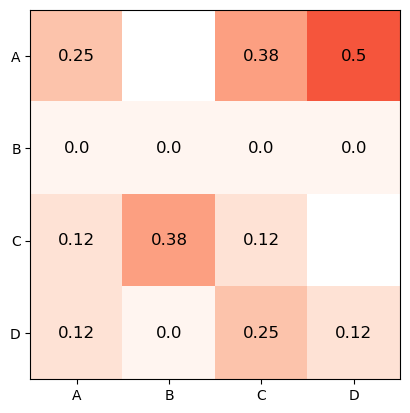

In [37]:
trainseqs = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs if seq not in trainseqs]

trainseqs_final = generate_complex_primitives(ops, all_syms, cue_dict) + pos_primitives
testseqs_final = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs_final = [seq for seq in testseqs_final if seq not in trainseqs_final]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
print('trainseqs_final ', trainseqs_final)
print('testseqs_final ', testseqs_final )
res1 = run_plot(trainseqs, testseqs, trainseqs_final,testseqs_final, cue_dict, xavier_gain, num_episodes=10)

fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, res1['dfs'], ax)

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 17], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 29], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'C'), ('+', 'B'), '=', 24], [('+', 'C'), ('+', 'C'), '=', 20], [('+', 'D'), ('+', 'B'), '=', 29], [('+', 'D'), ('+', 'C'), '=', 25], [('+', 'D'), ('+', 'D'), '=', 30]]
trainseqs_final  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 17], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs_final  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=

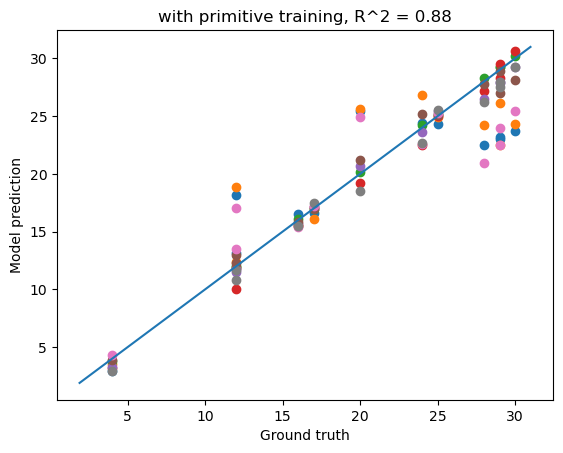

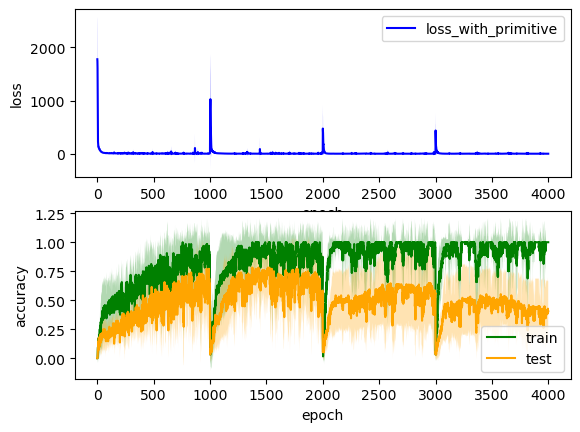

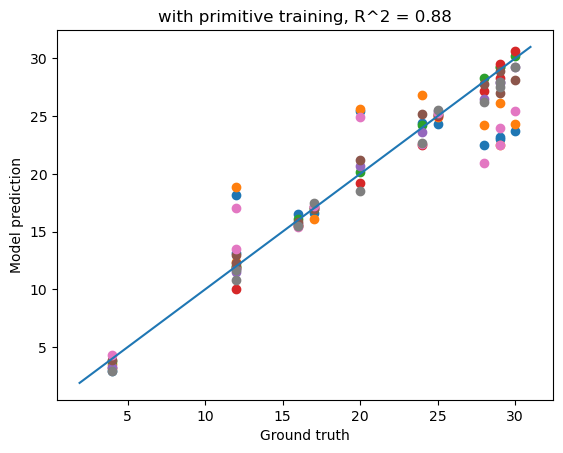

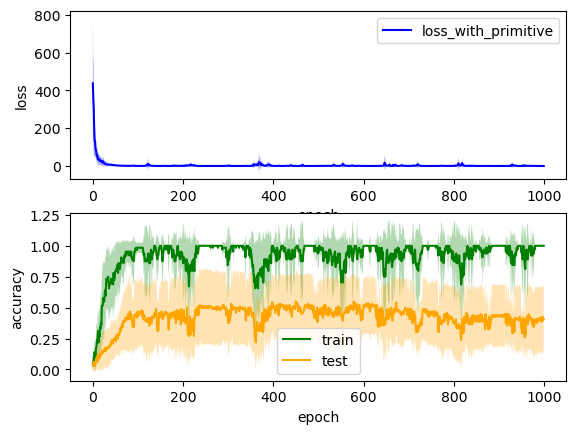

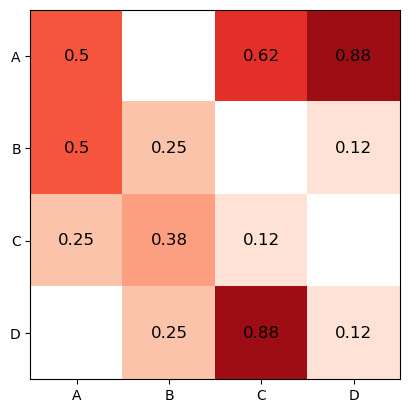

In [33]:
trainseqs = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs if seq not in trainseqs]

trainseqs_final = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs_final = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs_final = [seq for seq in testseqs_final if seq not in trainseqs_final]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
print('trainseqs_final ', trainseqs_final)
print('testseqs_final ', testseqs_final )
res1 = run_plot(trainseqs, testseqs, trainseqs_final,testseqs_final, cue_dict, xavier_gain, num_episodes=3)

fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, res1['dfs'], ax)

trainseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'B'), '=', 16], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'B'), ('+', 'D'), '=', 29], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'C'), ('+', 'B'), '=', 24], [('+', 'C'), ('+', 'C'), '=', 20], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 17], [('+', 'D'), ('+', 'B'), '=', 29], [('+', 'D'), ('+', 'C'), '=', 25], [('+', 'D'), ('+', 'D'), '=', 30], [('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 10], [('+', 'D'), '=', 15]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'B'), '=', 16], [('+', 'A'), ('+', 'C'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'C'), '=', 24], [('+', 'B'), ('+', 'D'), '=', 29], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'C'), 

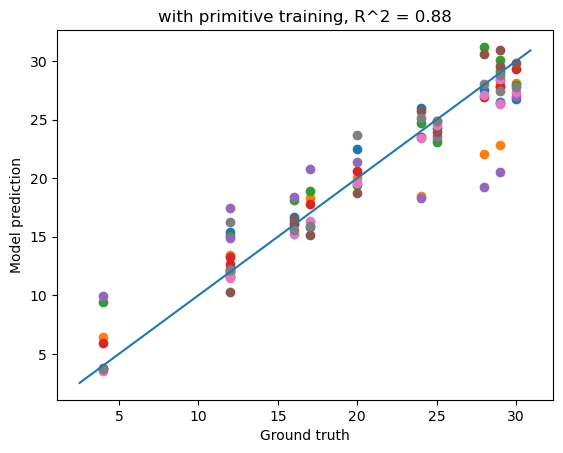

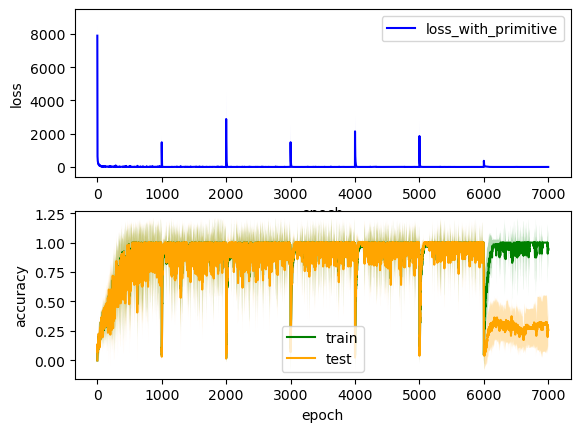

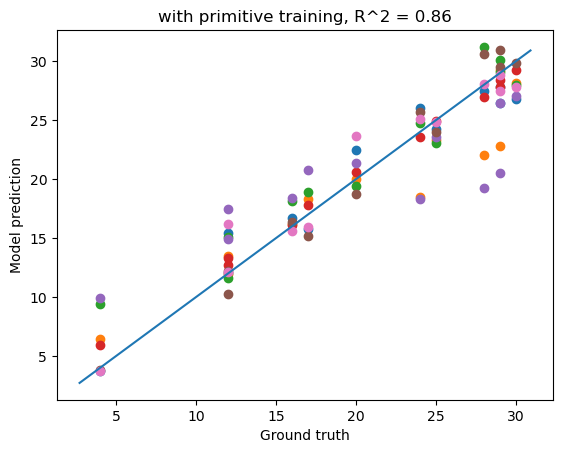

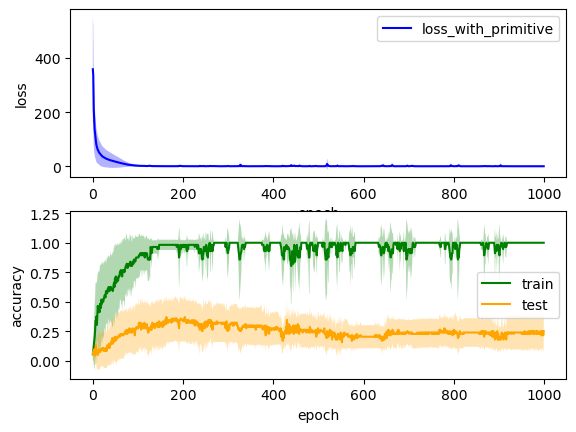

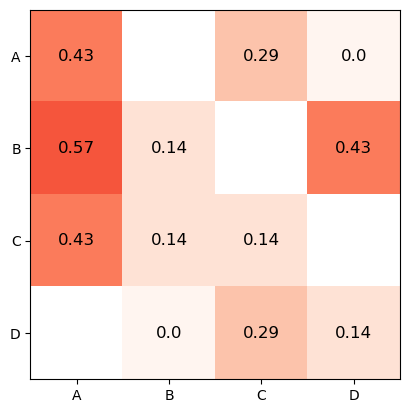

In [36]:
trainseqs = generate_pos_trials(ops, all_syms,all_syms, cue_dict) + pos_primitives
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)

trainseqs_final = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs_final = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs_final = [seq for seq in testseqs_final if seq not in trainseqs_final]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
print('trainseqs_final ', trainseqs_final)
print('testseqs_final ', testseqs_final )
res1 = run_plot(trainseqs, testseqs, trainseqs_final,testseqs_final, cue_dict, xavier_gain, num_episodes=6)

fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, res1['dfs'], ax)